In [1]:
import gym
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('data.csv') #Three stocks (R,X_s,X_b) Without predictors

In [23]:
print(data.iloc[1,1:4].values.reshape(1,3))

[[0.0 0.040000000000000001 0.01]]


In [3]:
#Initialize Neural Network
tf.reset_default_graph()
NN_input = tf.placeholder(shape=[1,3],dtype=tf.float32)
NN_weights = tf.Variable(tf.random_uniform([3,10],0,0.01))
Q_FA = tf.matmul(NN_input,NN_weights)
A_Max = tf.argmax(Q_FA,1)

#Calculate loss for the NN from the Q values
Q_Next = tf.placeholder(shape=[1,10],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(Q_Next - Q_FA))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

#Define Action Matrix (Now discrete case) 
A = np.matrix([[0.0, 0.0, 0.0],[0.1,0.1,0.1],[0.2,0.2,0.2],[-0.1,0.0,0.0],[-0.2,0.0,0.0],[0.0,-0.1,0.0],[0.0,0.0,-0.1],[0.0,-0.2,0.0],[0.0,0.0,-0.2],[-0.2,-0.2,-0.2]])

In [24]:
# initialize
init = tf.global_variables_initializer()
gamma = 1 # gamma parameter
epsilon = 0.1
train_data = 2000
d = False
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(train_data):
        #Reset environment and get first new observation (could be new draw from true distribution)
        s = data.iloc[1,1:4].values.reshape(1,3)
        rAll = 0
        j = 0
        #The Q-Network
        while j < 200:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a_int,allQ = sess.run([A_Max,Q_FA],feed_dict={NN_input:s})
            a = A[a_int,:]
            if np.random.rand(1) < epsilon:
                a = A[random.randint(0,9),:]
            #Get new state and reward from environment
            s1 = data.iloc[j+1,1:4].values.reshape(1,3)
            r = sum((-a*s.transpose() + a*s1.transpose()).transpose()) #reward: this is now the wealth gained from this step, but could be other rewards like utility
#             if r.all() > 0:
#                 d = True;
            #Obtain the new Q values by the Function Approximation Neural network
            Q = sess.run(Q_FA,feed_dict={NN_input:s1})
#             #Obtain maxQ' and set our target value for chosen action.
            Q1 = np.max(Q)
            targetQ = allQ
            targetQ[0,a_int] = r + gamma*Q1
 
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,NN_input],feed_dict={NN_input:s,Q_Next:targetQ})
            rAll += r
            s = s1
            if d == True:
                # increase the random actions over time in order to improve exploitation rather than exploration
                # only increase exploitation when a good action has been found (otherwise one exploits a bad solution)
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print("Average reward per episode: " + str((sum(rList)/train_data)))


Average reward over all episodes: [[47.637849999999951]]%


[[ -1.22636062e-04  -3.55064985e-05  -5.04351920e-05   1.85877569e-02
   -2.93535180e-03   4.20118158e-06   1.87137723e-03  -5.43007581e-03
    8.71072916e-06  -8.36151376e-05]]


ValueError: x and y can be no greater than 2-D, but have shapes (2000,) and (2000, 1, 1)

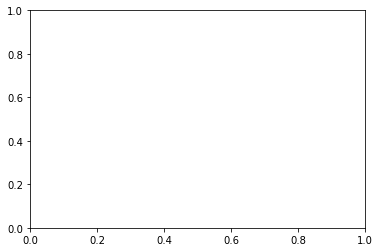

In [29]:
print(allQ)
plt.plot(rList)

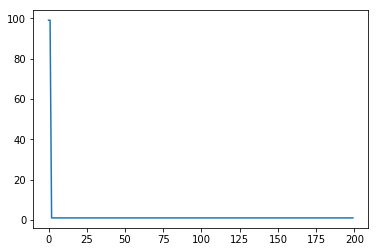

In [7]:
plt.plot(jList)